In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import gpflow
from scipy.stats import norm
import seaborn as sns
sns.set()
import ot

2022-06-14 16:22:53.365858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 16:22:53.365884: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
n_years = 10
x = np.arange(n_years * 12)
n_models = 3
n_reals_per_model = 100

Generate observations

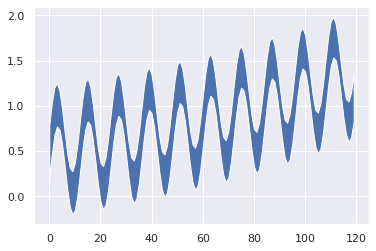

In [3]:
clim = 0.5 * np.sin(2 * np.pi * x / 12)
trend = 0.5 * np.exp(x / (n_years * 12))
sig = clim + trend
noise = 0.1 * (2.5 + 0.5 * np.cos(2 * np.pi * x / 12) - trend * 0.2)

plt.fill_between(x, sig - noise, sig + noise)
# plt.plot(x, trend + np.sin(2 * np.pi * x / 12))

Obs samples

In [4]:
obs_samples = np.asarray([np.random.normal(sig, noise) for i in range(100)]).T

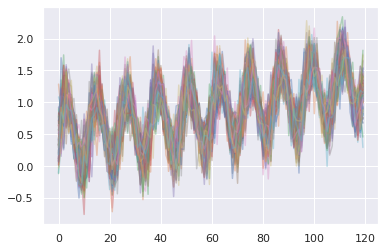

In [5]:
plt.plot(obs_samples, alpha=0.4)
plt.fill_between(x, sig - noise, sig + noise, alpha=0.6)

Models are biased samples of the truth

Model 1 has twice the variance

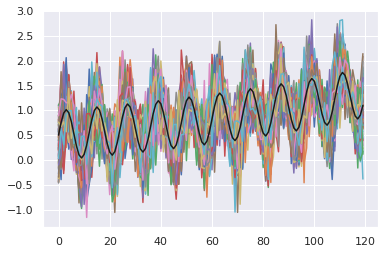

In [6]:
model1 = np.zeros(shape=[n_reals_per_model, len(x)])
for i in range(n_reals_per_model):
    model_real = np.random.normal(sig, noise * 1.55)
    model1[i] = model_real
    plt.plot(model_real)
plt.plot(sig, 'k')


Model 2 is biased

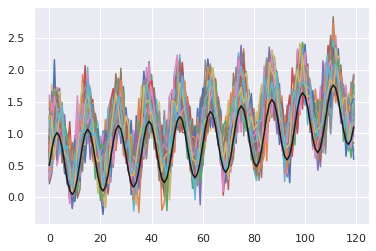

In [7]:
model2 = np.zeros(shape=[n_reals_per_model, len(x)])
for i in range(n_reals_per_model):
    model_real = np.random.normal(sig + 0.3, noise)
    model2[i] = model_real
    plt.plot(model_real)
plt.plot(sig, 'k')

Model 3 has a changing bias and noise

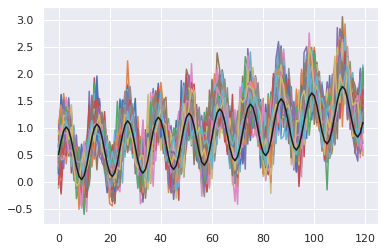

In [8]:
model3 = np.zeros(shape=[n_reals_per_model, len(x)])
for i in range(n_reals_per_model):
    model_real = np.random.normal(sig + np.linspace(0, 0.3, len(x)), noise + np.linspace(0, 0.1, len(x)))
    model3[i] = model_real
    plt.plot(model_real)
plt.plot(sig, 'k')

A naive multi model mean would look like this

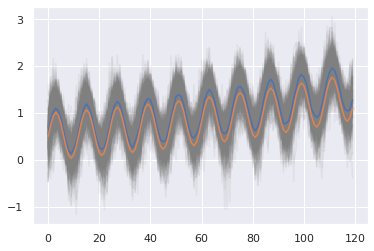

In [9]:
all_models = np.vstack([model1, model2, model3])

naive_mean = all_models.mean(axis=0)
naive_std = all_models.std(axis=0)

plt.fill_between(x, naive_mean - naive_std, naive_mean + naive_std, alpha=0.4)
for i in range(all_models.shape[0]):
    plt.plot(all_models[i], alpha=0.1, color='gray')

plt.plot(x, naive_mean)
plt.plot(x, sig)



First step is to find the mean and std of each model

In [10]:
model1_mean = model1.mean(axis=0)
model2_mean = model2.mean(axis=0)
model3_mean = model3.mean(axis=0)

model1_std = model1.std(axis=0)
model2_std = model2.std(axis=0)
model3_std = model3.std(axis=0)

Log likelihood calculation

In [11]:
x = np.linspace(-6,6,100)
xs = np.repeat(x, n_years * 12).reshape(-1, n_years * 12)

dist_m1 = norm(model1_mean, model1_std)
dist_m2 = norm(model2_mean, model2_std)
dist_m3 = norm(model3_mean, model3_std)
dist_obs = norm(sig, noise)

pdf_m1 = dist_m1.pdf(xs).T
pdf_m2 = dist_m2.pdf(xs).T
pdf_m3 = dist_m3.pdf(xs).T
pdf_obs = dist_obs.pdf(xs).T



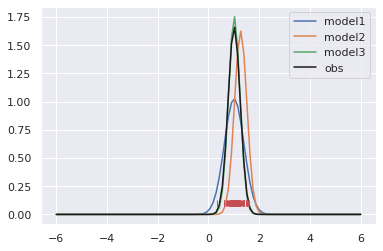

In [12]:
t_idx = 3
plt.plot(x, pdf_m1[t_idx], label='model1')
plt.plot(x, pdf_m2[t_idx], label='model2')
plt.plot(x, pdf_m3[t_idx], label='model3')
plt.plot(x, pdf_obs[t_idx], 'k', label='obs')

plt.plot(obs_samples[t_idx], len(obs_samples[t_idx]) * [0.1], '|')

plt.legend()


In [13]:
log_like_m1 = np.mean(dist_m1.logpdf(obs_samples.T), axis=0)
log_like_m2 = np.mean(dist_m2.logpdf(obs_samples.T), axis=0)
log_like_m3 = np.mean(dist_m3.logpdf(obs_samples.T), axis=0)

log_like_obs = np.mean(dist_obs.logpdf(obs_samples.T), axis=0)

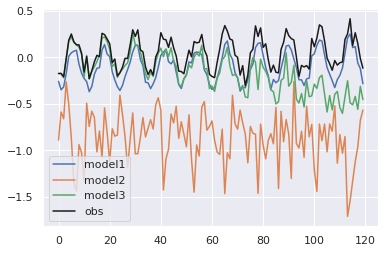

In [14]:
plt.plot(log_like_m1, label='model1')
plt.plot(log_like_m2, label='model2')
plt.plot(log_like_m3, label='model3')
plt.plot(log_like_obs, 'k', label='obs')

plt.legend()


Color schemes

In [15]:
cmap = sns.color_palette('Set2', 3)

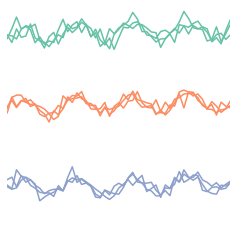

In [16]:
t_len = 48

plt.figure(figsize=(4,4))
for i_m, m in enumerate([model1, model2, model3]):
    ax = plt.subplot(3, 1, i_m + 1)
    for i in range(3):
        ax.plot(m[i].T, c=cmap[i_m])
        ax.set_xlim([0, t_len])
        sns.despine()
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_axis_off()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_ylim([-1.75, 2.25])

plt.show()

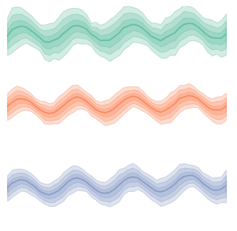

In [17]:

plt.figure(figsize=(4,4))
means = [model1_mean, model2_mean, model3_mean]
stds = [model1_std, model2_std, model3_std]

for i_m, vals in enumerate(zip(means, stds)):
    m, s = vals
    ax = plt.subplot(3, 1, i_m + 1)
    for i in range(3):
        ax.fill_between(np.arange(t_len), m[:t_len] - s[:t_len], m[:t_len] + s[:t_len], color=cmap[i_m], alpha=0.1)
        ax.fill_between(np.arange(t_len), m[:t_len] - 2 * s[:t_len], m[:t_len] + 2 * s[:t_len], color=cmap[i_m], alpha=0.1)
        ax.fill_between(np.arange(t_len), m[:t_len] - 3 * s[:t_len], m[:t_len] + 3 * s[:t_len], color=cmap[i_m], alpha=0.1)
    ax.plot(np.arange(t_len), m[:t_len], color=cmap[i_m])
    ax.set_xlim([0, t_len])
    ax.set_ylim([-1.75, 2.25])
    sns.despine()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

At a time slice

In [58]:
x = np.linspace(-6,6,1000)
xs = np.repeat(x, n_years * 12).reshape(-1, n_years * 12)

dist_m1 = norm(model1_mean, model1_std)
dist_m2 = norm(model2_mean, model2_std)
dist_m3 = norm(model3_mean, model3_std)
dist_obs = norm(sig, noise)

pdf_m1 = dist_m1.pdf(xs).T
pdf_m2 = dist_m2.pdf(xs).T
pdf_m3 = dist_m3.pdf(xs).T
pdf_obs = dist_obs.pdf(xs).T

Plots for figure

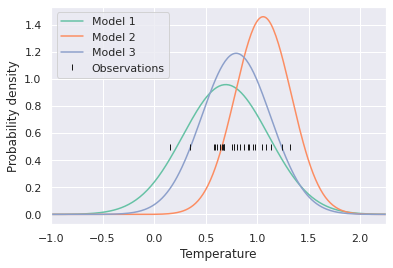

In [59]:
t_idx = 48
plt.plot(x, pdf_m1[t_idx], label='Model 1', color=cmap[0])
plt.plot(x, pdf_m2[t_idx], label='Model 2', color=cmap[1])
plt.plot(x, pdf_m3[t_idx], label='Model 3', color=cmap[2])

plt.plot(obs_samples[t_idx][:25], len(obs_samples[t_idx][:25]) * [0.5], 'k|', label='Observations')
plt.xlim([-1, 2.25])
plt.xlabel('Temperature')
plt.ylabel('Probability density')

plt.legend()
plt.show()

Model weights

In [60]:
weight1 = np.exp(log_like_m1)
weight2 = np.exp(log_like_m2)
weight3 = np.exp(log_like_m3)

weight_tot = weight1 + weight2 + weight3

weight_norm1 = weight1/weight_tot
weight_norm2 = weight2/weight_tot
weight_norm3 = weight3/weight_tot


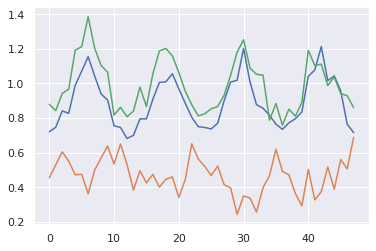

In [61]:
plt.plot(np.exp(log_like_m1)[:t_len], label='Model 1')
plt.plot(np.exp(log_like_m2)[:t_len], label='Model 2')
plt.plot(np.exp(log_like_m3)[:t_len], label='Model 3')

Text(0, 0.5, 'Model weight')

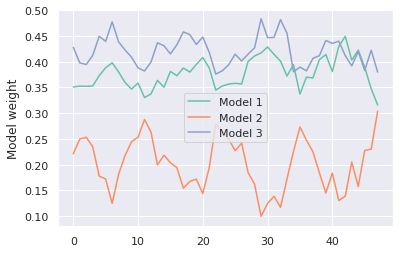

In [62]:
plt.plot(weight_norm1[:t_len], label='Model 1', color=cmap[0])
plt.plot(weight_norm2[:t_len], label='Model 2', color=cmap[1])
plt.plot(weight_norm3[:t_len], label='Model 3', color=cmap[2])
plt.legend()
plt.ylabel('Model weight')

Weights are used to construct a weighted barycentre

In [97]:
def gaussian_barycentre(
    means,
    std_devs,
    weights,
    tolerance: float = 1e-6,
    init_var=1.0,
    as_hist: bool = False,
    x=np.arange(300),
):
    barycentre_variance = init_var
    while True:
        candidate_variance = 0

        for w, s in zip(weights, std_devs):
            candidate_variance += w* np.sqrt(s* np.sqrt(barycentre_variance) * s)

        if candidate_variance - barycentre_variance < tolerance:
            barycentre_variance = candidate_variance
            break
        else:
            barycentre_variance = candidate_variance
    mu = np.sum(weights * means)
    sigma = barycentre_variance
    if as_hist:
        return norm(mu, sigma).pdf(x)
    else:
        return mu, sigma

In [98]:
bary_mus = []
bary_sds = []

for t in range(t_len):

    bary_mu, bary_sd = gaussian_barycentre(
        np.asarray([model1_mean[t], model2_mean[t], model3_mean[t]]),
        np.asarray([model1_std[t], model2_std[t], model3_std[t]]),
        np.asarray([weight_norm1[t], weight_norm2[t], weight_norm3[t]])
        )
    bary_mus.append(bary_mu)
    bary_sds.append(bary_sd)

dist_w = norm(bary_mus, bary_sds)
pdf_w = dist_w.pdf(xs[:, :t_len]).T

In [99]:
nbary_mus = []
nbary_sds = []

for t in range(t_len):

    bary_mu, bary_sd = gaussian_barycentre(
        np.asarray([model1_mean[t], model2_mean[t], model3_mean[t]]),
        np.asarray([model1_std[t], model2_std[t], model3_std[t]]),
        np.asarray([1/3] * 3)
        )
    nbary_mus.append(bary_mu)
    nbary_sds.append(bary_sd)


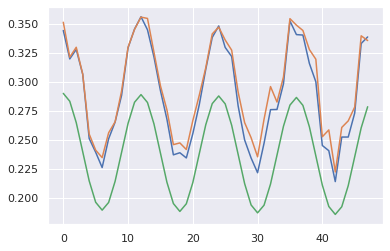

In [100]:
plt.plot(nbary_sds)
plt.plot(bary_sds)
plt.plot(noise[:t_len])



(0.0, 48.0)

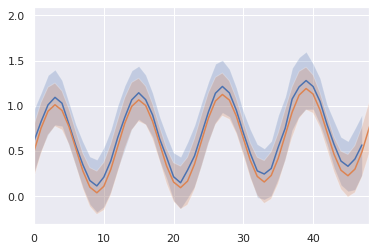

In [101]:
bm = np.asarray(bary_mus)
bs = np.asarray(bary_sds)

plt.plot(bm)
plt.fill_between(np.arange(t_len), bm - bs, bm + bs, alpha=0.25)
plt.plot(sig)
plt.fill_between(np.arange(120), sig - noise, sig + noise, alpha=0.25)

plt.xlim([0, t_len])

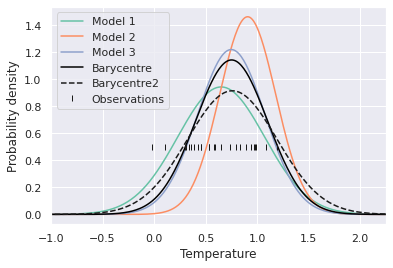

In [102]:
t_idx = 36
plt.plot(x, pdf_m1[t_idx], label='Model 1', color=cmap[0])
plt.plot(x, pdf_m2[t_idx], label='Model 2', color=cmap[1])
plt.plot(x, pdf_m3[t_idx], label='Model 3', color=cmap[2])
plt.plot(x, pdf_w[t_idx], label='Barycentre', color='black')
plt.plot(x, weighted_barycentre(t_idx), 'k--', label='Barycentre2')


plt.plot(obs_samples[t_idx][:25], len(obs_samples[t_idx][:25]) * [0.5], 'k|', label='Observations')
plt.xlim([-1, 2.25])
plt.xlabel('Temperature')
plt.ylabel('Probability density')

plt.legend()
plt.show()

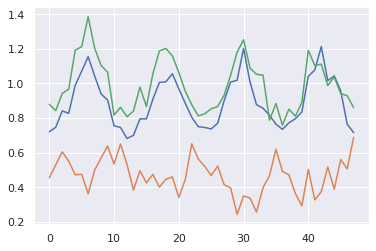

In [72]:
plt.plot(np.exp(log_like_m1)[:t_len], label='model1')
plt.plot(np.exp(log_like_m2)[:t_len], label='model2')
plt.plot(np.exp(log_like_m3)[:t_len], label='model3')

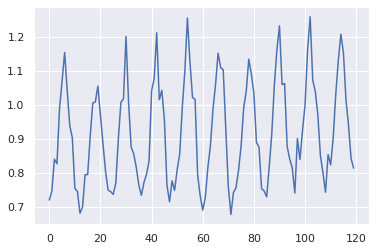

In [73]:
plt.plot(np.exp(log_like_m1))